# mCT DL-HMC inference test template - baseline V8
Works for both single and multi subjects studies. <br>
Last update (01/28):Modify the google service related code and function

20230123: first version, DLHMC baseline, use point cloud, resize 96x96x64;<br>
20230130: second version, modify the evaluation;<br>
20230203: third version, used for suv norm resized 1s recon.<br>
20230208: ues unique ID for identification, update the evaluation<br>
20230209: test for memory, use normal cache; small encoder from ISBI paper<br>
20230217: use new sampling and data loader;<br>
20230219: data augmentation;<br>


In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    Spacingd, \
    ToTensord,  \
    DataStatsd, \
    ToDeviced
from monai.data import list_data_collate
import torch
import pytorch_lightning as pl
from torchsummary import summary
monai.config.print_config()
import sys
sys.path.append(r'../util/python')
import mCTdata_vicra_toolbox
import nibabel; nibabel.imageglobals.logger.setLevel(40)

# New transforms 

sys.path.append(r'../')

from dlhmc.transforms import (
    CreateImageStack,
    ComputeRelativeMotion,
    RandSamplePET,
    ComputeRelativeMotiond,
    CreateImageStackd,
    RandSamplePETd,
)

from dlhmc.utils.data import (
    concatenate_vicra,
    split_dataset
)

2023-03-05 03:03:22,441 - Created a temporary directory at /tmp/tmpm9rg2n6y
2023-03-05 03:03:22,442 - Writing /tmp/tmpm9rg2n6y/_remote_module_non_scriptable.py
MONAI version: 1.0.1
Numpy version: 1.23.4
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home1/tz323/anaconda3/envs/dl-hmc_2301/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UN

## Data loading and sampling

In [2]:
# Load available data
#!!! Function get_data & print_info needs update

from mCTdata_summary_toolbox import get_data, print_info

df, df_ready, patients_ready =get_data('dl-hmc-data-analysis-08b527b43bc1.json', ['FPEB'])
print_info('dl-hmc-data-analysis-08b527b43bc1.json', ['FPEB'])

For tracer  FPEB   24  patients out of  24  are ready.
Ready patients are ['DC251_28608', 'DC251_28497', 'DC251_28504', 'DP162_27423', 'DP162_28061', 'DP162_28064', 'EC878_27647', 'EC878_27410', 'EC878_27644', 'JV527_27033', 'JV527_27031', 'JV527_27020', 'KS553_28733', 'KS553_28544', 'KS553_28529', 'MH419_27598', 'MH419_27361', 'MH419_27612', 'MM537_27024', 'MM537_27026', 'MM537_27028', 'RA253_28092', 'RA253_28137', 'RA253_28138']


In [3]:
''' You can also get and visualize information using other functions of the dataset_summary toolbox, such as

-compute_delta_T: compute delta_T for each patient and add it to the summary
-plot_delta_T_all: plot the delta_T computed by compute_delta_T
-delta_T_norm: normalizes delta_T and plots it
-delta_T_smoothed: smoothes delta_T_norm and plots it
-data_analysis_display: displays information about the motion (magnitude, when do the major movements occur, mean and SD of delta_T...)
-average_motion: computes and plot the average delta_T at each second among patients
-make_gif_3Dcloud: make a gif with the 3D cloud data for a list of patients '''

' You can also get and visualize information using other functions of the dataset_summary toolbox, such as\n\n-compute_delta_T: compute delta_T for each patient and add it to the summary\n-plot_delta_T_all: plot the delta_T computed by compute_delta_T\n-delta_T_norm: normalizes delta_T and plots it\n-delta_T_smoothed: smoothes delta_T_norm and plots it\n-data_analysis_display: displays information about the motion (magnitude, when do the major movements occur, mean and SD of delta_T...)\n-average_motion: computes and plot the average delta_T at each second among patients\n-make_gif_3Dcloud: make a gif with the 3D cloud data for a list of patients '

In [3]:
df_ready

,PatientID,Name,InjectionID,UniqueID,date,Weight_kg,Injtime,dose_mCi,tracer,isotope,protocol,Diagnosis,Secondary_Diagnosis,pstate,MotMag_entire_EM_mm,Status (Done/Running),MCCOD QA,Training/Testing_TZ
0,DC251,"DC251, human",28608,DC251_28608,2021/11/10,86.1,12:29:06,1.74,FPEB,F-18,fpeb_sam,Healthy_Control,,baseline,,Done,Good,Training
1,DC251,"DC251, human",28497,DC251_28497,2021/10/19,88,13:48:56,4.75,FPEB,F-18,fpeb_sam,Healthy_Control,,post-dose_one,,Done,Good,Training
2,DC251,"DC251, human",28504,DC251_28504,2021/10/20,88,11:59:18,4.73,FPEB,F-18,fpeb_sam,Healthy_Control,,post-dose_two,,Done,Good; No motion,Training
3,DP162,"DP162, human",27423,DP162_27423,2021/5/26,68,13:44:39,4.28,FPEB,F-18,fpeb_sam,Healthy_Control,,baseline,,Done,Good,Training
4,DP162,"DP162, human",28061,DP162_28061,2021/8/24,70,13:50:21,3.25,FPEB,F-18,fpeb_sam,Healthy_Control,,post-dose_one,,Done,Not perfect,Training
5,DP162,"DP162, human",28064,DP162_28064,2021/8/25,70,11:49:06,4.72,FPEB,F-18,fpeb_sam,Healthy_Control,,post-dose_two,,Done,Not perfect; Major movements,Testing
6,EC878,"EC878, human",27647,EC878_27647,2021/6/30,106,11:36:52,4.48,FPEB,F-18,fpeb_sam,Healthy_Control,,post-dose_two,,Done,Good.,Training
7,EC878,"EC878, human",27410,EC878_27410,2021/5/25,106.5,13:56:51,4.45,FPEB,F-18,fpeb_sam,Healthy_Control,,baseline,,Done,Wrong Vicra,Testing
8,EC878,"EC878, human",27644,EC878_27644,2021/6/29,106,13:52:01,4.42,FPEB,F-18,fpeb_sam,Healthy_Control,,post-dose_one,,Done,Good; No motion,Training
9,JV527,"JV527, human",27033,JV527_27033,2021/4/14,65.4,14:58:53,4.68,FPEB,F-18,fpeb_sam,Healthy_Control,,baseline,,Done,Good,Training


In [3]:
tr_set=['RA253_28137']
test_set=['RA253_28137']

In [3]:

tr_set=['KS553_28529','MH419_27612','MM537_27028','MH419_27361']
test_set=['KS553_28529','MH419_27612','MM537_27028','MH419_27361']

In [4]:
inters=set(tr_set) & set(test_set)
if len(inters)>0:
    print('Careful, there\'s data contamination between the training and testing sets. The duplicates are: ', inters)

Careful, there's data contamination between the training and testing sets. The duplicates are:  {'RA253_28137'}


In [5]:
# Split and sample the training set

from mCTdata_summary_toolbox import compute_delta_T 
from mCTdata_prep_toolbox import delta_T_magnitude, Relative_motion_A_to_B_12, build_legal_dataset, deal_dataframe, clean_df
from sampling_toolbox import data_split_sample, add_T_deltaT

# Get the summaries

summaries, delta_T_all=compute_delta_T(['FPEB'], tr_set)

In [6]:
# Building transform
KEYS = ['ThreeD_Cloud_ref','ThreeD_Cloud_mov'] 

train_transforms = Compose([
    LoadImaged(keys=KEYS, reader='NibabelReader', as_closest_canonical=False),
    monai.transforms.EnsureChannelFirstd(keys=KEYS), # previously AddChanneld
    Orientationd(keys=KEYS, axcodes='RAS'),
    ToTensord(keys=KEYS)    
])

## Build network

In [7]:
import torch.nn as nn
from monai.networks.blocks import Convolution

# Encoder + intermediate layer

simple_enc_inter=nn.Sequential()
simple_enc_inter.add_module("conv1", Convolution(
    strides=2,
    spatial_dims=3,
    kernel_size=5,
    in_channels=1,
    out_channels=32,
    adn_ordering="ADN",
    act=("prelu", {"init": 0.2}),
    dropout=0.1,
#     norm=("layer", {"normalized_shape": (10, 10, 10)}),
    padding=(0,0,0)
))
simple_enc_inter.add_module("conv2", Convolution(
    strides=2,
    kernel_size=5,
    spatial_dims=3,
    in_channels=32,
    out_channels=64,
    adn_ordering="ADN",
    act=("prelu", {"init": 0.2}),
    dropout=0.1,
#     norm=("layer", {"normalized_shape": (10, 10, 10)}),
    padding=(0,0,0)
))
simple_enc_inter.add_module("conv3", Convolution(
    strides=2,
    kernel_size=5,
    spatial_dims=3,
    in_channels=64,
    out_channels=128,
    adn_ordering="ADN",
    act=("prelu", {"init": 0.2}),
    dropout=0.1,
#     norm=("layer", {"normalized_shape": (10, 10, 10)}),
    padding=(0,0,0)
))
simple_enc_inter.add_module("intermediate", Convolution(
    strides=2,
    kernel_size=3,
    spatial_dims=3,
    in_channels=128,
    out_channels=16,
    adn_ordering="ADN",
    act=("prelu", {"init": 0.2}),
    dropout=0.1,
#     norm=("layer", {"normalized_shape": (10, 10, 10)}),
    padding=(0,0,0)
))

In [8]:
class PETRegNet(pl.LightningModule):
    
    def __init__(self, dropout=0.3):
        super().__init__()
        
        self.dropout = dropout
        
        self.simple_enc_inter=simple_enc_inter
        
        self.regression_layers = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(256, 6),
        )

        monai.utils.set_determinism(seed=42)
        self.simple_enc_inter.apply(self._init_weights)
        self.regression_layers.apply(self._init_weights)
        
        self.loss_function = torch.nn.MSELoss()
        
    def _init_weights(self, m):
        classname = m.__class__.__name__
        if "conv" in classname.lower():
            if hasattr(m, 'weight'):
                torch.nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.xavier_normal_(m.bias[None])
        elif "linear" in classname.lower():
            if hasattr(m, 'weight'):
                torch.nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.xavier_normal_(m.bias[None])
        
    def forward(self, x1, x2):
        y1=self.simple_enc_inter(x1)
        y2=self.simple_enc_inter(x2)

        # Encoder and intermediate layer 
        y1_flat=torch.flatten(y1, start_dim=1)#to feed in the regression layers 
        y2_flat=torch.flatten(y2, start_dim=1)#to feed in the regression layers 

        #Regression
        y = torch.cat([y1_flat,y2_flat], dim=-1)
        y = self.regression_layers(y)

        return y

    def prepare_data(self):
        # set deterministic training for reproducibility
        monai.utils.misc.set_determinism(seed=42)

    def training_step(self, batch, batch_idx):
        x1 = batch["ThreeD_Cloud_ref"]
        x2 = batch["ThreeD_Cloud_mov"]
        ref_time = batch['ScanStart_ref']
        mov_time = batch['ScanStart_mov']
        x_t = torch.stack([ref_time, mov_time], dim=1)
        gt_reg = batch["VICRA_rel"].float()

        syn_mov_list = list()
        syn_rev_list = list()
        for mov_img, rel_motion in zip(x2, gt_reg):
            # image
            T_syn, T_syn_monai = generate_synthetic_motion(
                trans_amp=10,rot_amp=5,resl_pix=resl_pix)
            syn_mov_img = Affine(
                            rotate_params=tuple(T_syn_monai[3:]),
                            translate_params=tuple(T_syn_monai[:3]),
                            mode = 'bilinear',
                            padding_mode='zeros')(mov_img)[0]
            syn_mov_list.append(syn_mov_img)
            
            # motion
            T_line = mCTdata_vicra_toolbox.RotTransMatrix_6Params(T_syn,2)
            T_matrix = np.reshape(T_line,(3,4))
            T_matrix = np.insert(T_matrix, 3, np.array([0, 0, 0, 1]), axis=0)
            T_matrix_inv = np.linalg.inv(T_matrix)
            
            rel_matrix = np.reshape(rel_motion,(3,4))
            rel_matrix = np.insert(rel_matrix, 3, np.array([0, 0, 0, 1]), axis=0)
            
            syn_matrix = np.dot(rel_matrix, T_matrix_inv)
            syn_line = torch.from_numpy(np.reshape(syn_matrix, 16)[0:12])
            syn_rev_list.append(syn_line)

        syn_x2 = torch.stack(syn_mov_list)
        syn_reg = torch.stack(syn_rev_list).float().to(device)

        y = self.forward(x1,syn_x2,x_t)
        
        loss = self.loss_function(y, syn_reg)        
        return {"loss": loss}
        
    
    def training_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    
    def validation_step(self, batch, batch_idx):
        x1 = batch["ThreeD_Cloud_ref"]
        x2 = batch["ThreeD_Cloud_mov"]
        gt_reg = batch["VICRA_rel"].float()

        i_6_list = list()
        for i_12 in gt_reg:
            i_6 = np.reshape(i_12,12)
            i_6 = torch.from_numpy(mCTdata_vicra_toolbox.RotTransMatrix_6Params(i_6,1))
            i_6_list.append(i_6)

        gt_reg_6 = torch.stack(i_6_list).float().to(device)    
        y = self.forward(x1,x2)
        loss = self.loss_function(y, gt_reg_6)
        return {"val_loss": loss}

    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)

        # Log the value for model checkpoint saving
        self.log('val_loss', avg_loss.item()) #added .item(), otherwise validation wouldn't work 

    def configure_optimizers(self):
        total_params = list(self.simple_enc_inter.parameters()) + list(self.regression_layers.parameters()) 
        opt = torch.optim.Adam(total_params, lr=5e-4)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=1000, gamma=0.98),
                     'name': 'Learning Rate'}
        return [opt], [scheduler]

In [9]:
from torchinfo import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PETRegNet().to(device)
#summary(model, [(1,1,96,96,64),(1,1,96,96,64),(1,2)],depth=2)

In [10]:
MODEL_PATH = os.path.join('.','/data16/private/tz323/dev/mCT-dl-hmc/notebooks/V8_ver')
print('MODEL_PATH={}'.format(MODEL_PATH))

MODEL_PATH=/data16/private/tz323/dev/mCT-dl-hmc/notebooks/V8_ver


## Testing and evaluation

In [11]:
from mCTdata_evaluation_toolbox import build_df_results, show_df_loss, plot_vicra_network, plot_diff_vicra_network, save_synthetic_vicra, print_loss

### Testing on testing patients (for multisubject studies)

In [12]:
summaries_test, delta_T_all_test=compute_delta_T(['FPEB'], test_set)
df_test=[]
predictions=[]
df_input_diff_all=[]

for i in range(len(test_set)):
    df_test.append(deal_dataframe(summaries_test[i]))

In [13]:
df_test[0]

,PatientID,InjectionID,PatientType,Listmode,ScanStartTime,InjectionTime,ScanStartTime_ms,InjectionTime_ms,ScanStart,ScanEnd,...,VC_32,VC_33,VC_34,Total_MC_NAC_MOLAR,MATRIX,UniqueID,T,delta_T,relative_T,delta_relative_T
0,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3600,3601,...,0.036567,0.999295,-0.974876,/data16/public/registration-brain_PET/data/mCT...,"[0.99974, -0.021418, -0.007776, -3.32203, 0.02...",MH419_27612,"[-3.32203, 5.244722, -0.974876, 2.105634607284...",0.000000,"[4.440892098500626e-16, 8.881784197001252e-16,...",0.000000
1,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3601,3602,...,0.034904,0.999357,-0.755787,/data16/public/registration-brain_PET/data/mCT...,"[0.999742, -0.02145, -0.007488, -3.453345, 0.0...",MH419_27612,"[-3.453345, 5.016619, -0.755787, 2.00993500530...",0.126709,"[-0.13422364935836173, -0.21707409927988142, 0...",0.126711
2,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3602,3603,...,0.034697,0.999363,-0.864858,/data16/public/registration-brain_PET/data/mCT...,"[0.99974, -0.021499, -0.007555, -3.511015, 0.0...",MH419_27612,"[-3.511015, 5.045713, -0.864858, 1.99814806184...",0.099159,"[-0.1921974793216874, -0.19075952376558547, 0....",0.099167
3,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3603,3604,...,0.035868,0.999320,-0.774733,/data16/public/registration-brain_PET/data/mCT...,"[0.999736, -0.0216, -0.007826, -3.29046, 0.021...",MH419_27612,"[-3.29046, 5.151755, -0.774733, 2.065686642141...",0.051410,"[0.03131089741255266, -0.08624092865942323, 0....",0.051416
4,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3604,3605,...,0.035673,0.999328,-0.926366,/data16/public/registration-brain_PET/data/mCT...,"[0.999744, -0.021286, -0.007694, -3.319155, 0....",MH419_27612,"[-3.319155, 5.148712, -0.926366, 2.05420274049...",0.014304,"[0.0012617112369022188, -0.09421141715070114, ...",0.014298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5395,5396,...,0.073860,0.997254,0.471717,/data16/public/registration-brain_PET/data/mCT...,"[0.999969, -0.006089, -0.005055, -0.70622, 0.0...",MH419_27612,"[-0.70622, 9.191917, 0.471717, 4.2375613983883...",29.856436,"[2.710867817390939, 3.9405216152836138, 1.2802...",29.884133
1796,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5396,5397,...,0.073948,0.997243,0.782921,/data16/public/registration-brain_PET/data/mCT...,"[0.999966, -0.005883, -0.005832, -0.573277, 0....",MH419_27612,"[-0.573277, 9.161725, 0.782921, 4.242810748584...",31.360763,"[2.8458013807120284, 3.9188893118479298, 1.591...",31.388869
1797,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5397,5398,...,0.074263,0.997221,0.874973,/data16/public/registration-brain_PET/data/mCT...,"[0.99997, -0.005449, -0.005563, -0.581711, 0.0...",MH419_27612,"[-0.581711, 9.075284, 0.874973, 4.260671616800...",31.102082,"[2.8363316496355893, 3.8360727151436107, 1.686...",31.131212
1798,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5398,5399,...,0.074327,0.997216,1.176387,/data16/public/registration-brain_PET/data/mCT...,"[0.999969, -0.005495, -0.005661, -0.554661, 0....",MH419_27612,"[-0.554661, 8.927728, 1.176387, 4.264401681743...",31.358281,"[2.862837346354004, 3.6990918502942387, 1.9929...",31.387368


In [13]:
len(df_test)

1

In [14]:
df_results_all=[]
y_list_all=[]
df_input_diff_all=[]

from copy import deepcopy

prediction_list = list()
for j in range(len(test_set)):

    df = df_test[j]

    #fixed reference time
    df_input_diff = mCTdata_vicra_toolbox.build_netinput_fixed_reference(df).reset_index()
    
    df_input_diff_all.append(df_input_diff)

    ##building testing dataloader
    test_dict = df_input_diff.to_dict('records')

    for i in range(len(test_dict)):
        x = test_dict[i]['ThreeD_Cloud_ref'].find('3D_Clouds_nii')
        fn_cloud1 = test_dict[i]['ThreeD_Cloud_ref'][0:x] + 'MOLAR_Recon_NAC_nii_suv_resize'
        x = x+13
        y = test_dict[i]['ThreeD_Cloud_ref'].find('3D_cloud')
        fn_cloud2 =  test_dict[i]['ThreeD_Cloud_ref'][x:y] + 'recon_suv_rz.nii'
        test_dict[i]['ThreeD_Cloud_ref'] = fn_cloud1 + fn_cloud2

        x = test_dict[i]['ThreeD_Cloud_mov'].find('3D_Clouds_nii')
        fn_cloud1 = test_dict[i]['ThreeD_Cloud_mov'][0:x] + 'MOLAR_Recon_NAC_nii_suv_resize'
        x = x+13
        y = test_dict[i]['ThreeD_Cloud_mov'].find('3D_cloud')
        fn_cloud2 =  test_dict[i]['ThreeD_Cloud_mov'][x:y] + 'recon_suv_rz.nii'
        test_dict[i]['ThreeD_Cloud_mov'] = fn_cloud1 + fn_cloud2

    # Create the Dataset
#     ds_test = monai.data.CacheDataset(data=test_dict, transform=train_transforms)
    ds_test = monai.data.Dataset(data=test_dict, transform=train_transforms)
    #ds_tr = monai.data.SmartCacheDataset(data=tr_dict,transform=train_transforms,replace_rate=1,cache_num=64,shuffle=True)
    # Create the DataLoader
    test_loader = monai.data.DataLoader(ds_test, batch_size=8, num_workers=2, collate_fn=list_data_collate)
    
    #calculate loss function and network output
    saved_model_path = os.path.join(MODEL_PATH,'PETRegNet-epoch=5579-val_loss=0.200.ckpt')
    loaded_model = PETRegNet.load_from_checkpoint(saved_model_path)

    loaded_model.eval()
    loaded_model.to(device)
    loss = 0
    loss_list = list()
    time_list = list()
    
    y_list = list()
    loss1 = []

    i=0
    for test_data in test_loader:
        x1 = test_data['ThreeD_Cloud_ref'].to(device)
        x2 = test_data['ThreeD_Cloud_mov'].to(device)
        time = test_data['delta_t']
        y = test_data['T'].cpu().numpy()
        y_test = loaded_model(x1, x2).detach().cpu().numpy()
        l = len(y_test)

        loss = y-y_test
        for jj in range(l):
            loss1=sum(np.square(loss[jj]))/len(loss[jj])
            loss_list.append(loss1)
            time_list.append(time.numpy()[jj])
            prediction_list.append(y_test[jj])
            y_list.append(y[jj])
        
        del test_data
    df_results = pd.DataFrame()
    y_list_all.append(y_list)
    df_results['Time'] = time_list
    df_results['Loss'] = loss_list
    df_results_all.append(df_results)


In [15]:
#save prediction list for MCCOD test
file_path = '/data16/private/tz323/dev/mCT-dl-hmc/notebooks/20211026_KS553_MCCOD_DLHMC.txt'
# Open the file for writing
with open(file_path, 'w') as file:
    # Write the list elements to the file
    for element in prediction_list:
        file.write('%s\n' % ' '.join(map(str, element)))

In [18]:
df_test[2]

,PatientID,InjectionID,PatientType,Listmode,ScanStartTime,InjectionTime,ScanStartTime_ms,InjectionTime_ms,ScanStart,ScanEnd,...,VC_33,VC_34,Total_MC_NAC_MOLAR,MATRIX,UniqueID,T,delta_T,relative_T,delta_relative_T,M
0,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3600,3601,...,0.999295,-0.974876,/data16/public/registration-brain_PET/data/mCT...,"[0.99974, -0.021418, -0.007776, -3.32203, 0.02...",MH419_27612,"[-3.32203, 5.244722, -0.974876, 2.105634607284...",0.000000,"[4.440892098500626e-16, 8.881784197001252e-16,...",0.000000,"[0.99974, -0.021418, -0.007776, -3.32203, 0.02..."
1,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3601,3602,...,0.999357,-0.755787,/data16/public/registration-brain_PET/data/mCT...,"[0.999742, -0.02145, -0.007488, -3.453345, 0.0...",MH419_27612,"[-3.453345, 5.016619, -0.755787, 2.00993500530...",0.126709,"[-0.13422364935836173, -0.21707409927988142, 0...",0.126711,"[0.999742, -0.02145, -0.007488, -3.453345, 0.0..."
2,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3602,3603,...,0.999363,-0.864858,/data16/public/registration-brain_PET/data/mCT...,"[0.99974, -0.021499, -0.007555, -3.511015, 0.0...",MH419_27612,"[-3.511015, 5.045713, -0.864858, 1.99814806184...",0.099159,"[-0.1921974793216874, -0.19075952376558547, 0....",0.099167,"[0.99974, -0.021499, -0.007555, -3.511015, 0.0..."
3,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3603,3604,...,0.999320,-0.774733,/data16/public/registration-brain_PET/data/mCT...,"[0.999736, -0.0216, -0.007826, -3.29046, 0.021...",MH419_27612,"[-3.29046, 5.151755, -0.774733, 2.065686642141...",0.051410,"[0.03131089741255266, -0.08624092865942323, 0....",0.051416,"[0.999736, -0.0216, -0.007826, -3.29046, 0.021..."
4,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,3604,3605,...,0.999328,-0.926366,/data16/public/registration-brain_PET/data/mCT...,"[0.999744, -0.021286, -0.007694, -3.319155, 0....",MH419_27612,"[-3.319155, 5.148712, -0.926366, 2.05420274049...",0.014304,"[0.0012617112369022188, -0.09421141715070114, ...",0.014298,"[0.999744, -0.021286, -0.007694, -3.319155, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5395,5396,...,0.997254,0.471717,/data16/public/registration-brain_PET/data/mCT...,"[0.999969, -0.006089, -0.005055, -0.70622, 0.0...",MH419_27612,"[-0.70622, 9.191917, 0.471717, 4.2375613983883...",29.856436,"[2.710867817390939, 3.9405216152836138, 1.2802...",29.884133,"[0.999969, -0.006089, -0.005055, -0.70622, 0.0..."
1796,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5396,5397,...,0.997243,0.782921,/data16/public/registration-brain_PET/data/mCT...,"[0.999966, -0.005883, -0.005832, -0.573277, 0....",MH419_27612,"[-0.573277, 9.161725, 0.782921, 4.242810748584...",31.360763,"[2.8458013807120284, 3.9188893118479298, 1.591...",31.388869,"[0.999966, -0.005883, -0.005832, -0.573277, 0...."
1797,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5397,5398,...,0.997221,0.874973,/data16/public/registration-brain_PET/data/mCT...,"[0.99997, -0.005449, -0.005563, -0.581711, 0.0...",MH419_27612,"[-0.581711, 9.075284, 0.874973, 4.260671616800...",31.102082,"[2.8363316496355893, 3.8360727151436107, 1.686...",31.131212,"[0.99997, -0.005449, -0.005563, -0.581711, 0.0..."
1798,MH419,27612,Real,/data4/mct/raw/20210623_MH419/MH419.PT.PET_07_...,12:15:51,12:15:58,44151000,44158000,5398,5399,...,0.997216,1.176387,/data16/public/registration-brain_PET/data/mCT...,"[0.999969, -0.005495, -0.005661, -0.554661, 0....",MH419_27612,"[-0.554661, 8.927728, 

In [ ]:
order = [KS553_28529,MH419_27361,MH419_27612,MM537_27028]

In [15]:
df_results_all[0].describe()

,Time,Loss
count,1800.00000,1800.000000
mean,899.50000,1.023690
std,519.75956,0.607909
min,0.00000,0.050538
25%,449.75000,0.578426
50%,899.50000,0.899344
75%,1349.25000,1.311665
max,1799.00000,4.253010


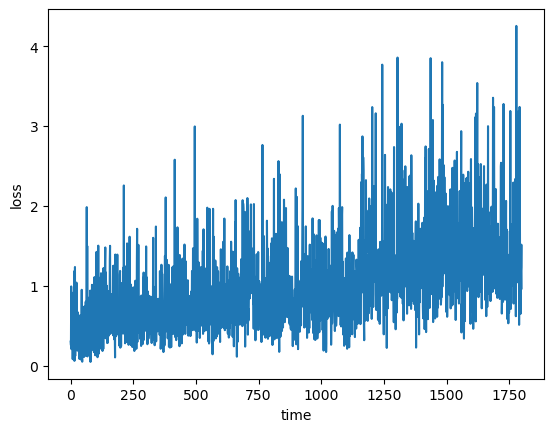

In [16]:
df_results_all[0]['Loss'].plot()
plt.xlabel('time') 
plt.ylabel('loss') 
plt.show()

In [17]:
df_results_test = build_df_results(test_set, df_input_diff_all, prediction_list).reset_index(drop=True)

In [18]:
df_results_test

,PatientID,UniqueID,ScanStart_ref,ScanStart_mov,tracer,vicra parameters,time,model parameters
0,RA253,RA253_28137,3600,3600,FPEB,"[-1.691749, 2.778658, 0.562393, 0.469260732318...",3600,"[-1.9066982300020796, 2.180331457961529, 1.079..."
1,RA253,RA253_28137,3600,3601,FPEB,"[-1.48927, 2.720519, 1.039301, 0.4547597866089...",3601,"[-1.9605485691909663, 2.3626946646518237, 0.48..."
2,RA253,RA253_28137,3600,3602,FPEB,"[-1.585624, 2.586528, 0.720047, 0.400768780330...",3602,"[-0.7207700902917089, 3.007260609704447, 1.165..."
3,RA253,RA253_28137,3600,3603,FPEB,"[-1.748073, 2.66871, 0.406905, 0.4110997364235...",3603,"[-1.7345471845776967, 2.8983338264224896, 1.49..."
4,RA253,RA253_28137,3600,3604,FPEB,"[-1.583251, 2.700638, 0.994096, 0.440391308006...",3604,"[-1.4274117366368142, 2.4091535244213547, 1.07..."
...,...,...,...,...,...,...,...,...
1795,RA253,RA253_28137,3600,5395,FPEB,"[-2.648776, 3.033347, -0.992819, -0.8363112019...",5395,"[-1.850368267128613, 2.5406769674054934, 0.291..."
1796,RA253,RA253_28137,3600,5396,FPEB,"[-2.536734, 3.423073, -0.599717, -0.6698542500...",5396,"[-2.040595087560542, 2.945348104889472, 1.4602..."
1797,RA253,RA253_28137,3600,5397,FPEB,"[-2.433228, 3.305007, -0.793221, -0.6863568128...",5397,"[-2.0038839113792144, 2.8905837132171834, 1.23..."
1798,RA253,RA253_28137,3600,5398,FPEB,"[-2.792987, 2.909917, -1.177945, -0.7675179029...",5398,"[-1.1734343985611462, 2.8995700634231927, 0.96..."


In [ ]:
# df_results_test.to_csv('results/DL-HMC_original_mulsub21.csv', index=False)

In [19]:
#finding the range for plot
index = 0
range_tr_up = -1000
range_tr_down = 1000
range_ro_up  = -1000
range_ro_down = 1000
for i in range(1800):
        temp = df_results_test['model parameters'][i+index*1800]
        if temp[0]>range_tr_up:
            range_tr_up = temp[0]
        if temp[0]<range_tr_down:
            range_tr_down = temp[0];
        if temp[1]>range_tr_up:
            range_tr_up = temp[1]
        if temp[1]<range_tr_down:
            range_tr_down = temp[1];
        if temp[2]>range_tr_up:
            range_tr_up = temp[2]
        if temp[2]<range_tr_down:
            range_tr_down = temp[2];
        if temp[3]>range_ro_up:
            range_ro_up = temp[3]
        if temp[3]<range_ro_down:
            range_ro_down = temp[3];
        if temp[4]>range_ro_up:
            range_ro_up = temp[4]
        if temp[4]<range_ro_down:
            range_ro_down = temp[4];
        if temp[5]>range_ro_up:
            range_ro_up = temp[5]
        if temp[5]<range_ro_down:
            range_ro_down = temp[5];

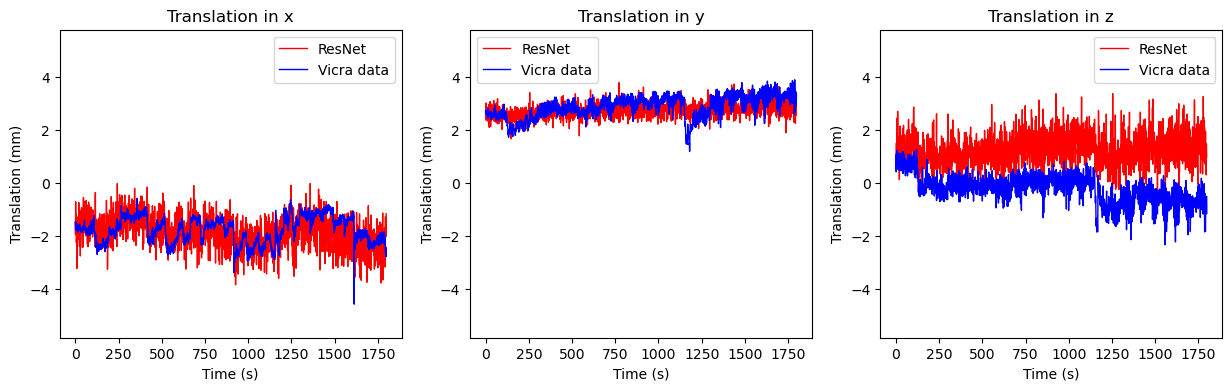

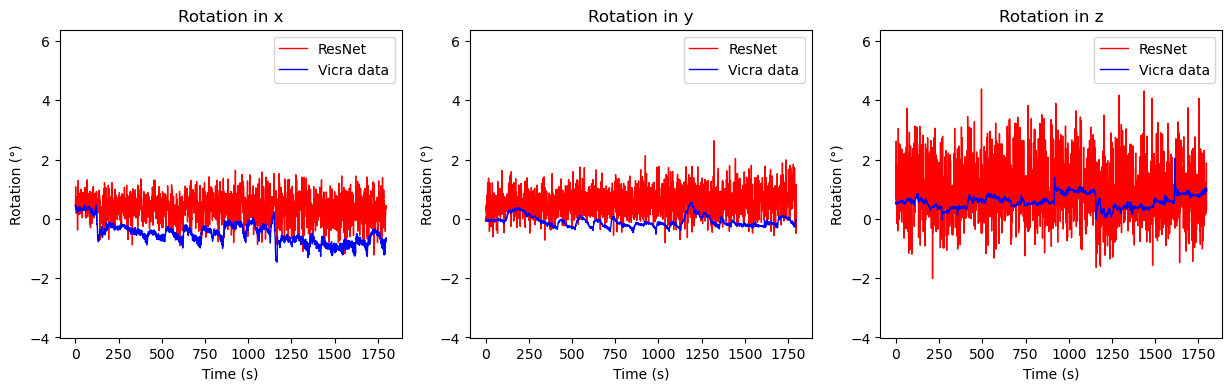

In [20]:
plot_vicra_network('FPEB', 'RA253_28137', df_results_test, [3601,5399], 'ResNet',[range_tr_down-2,range_tr_up+2],[range_ro_down-2,range_ro_up+2])

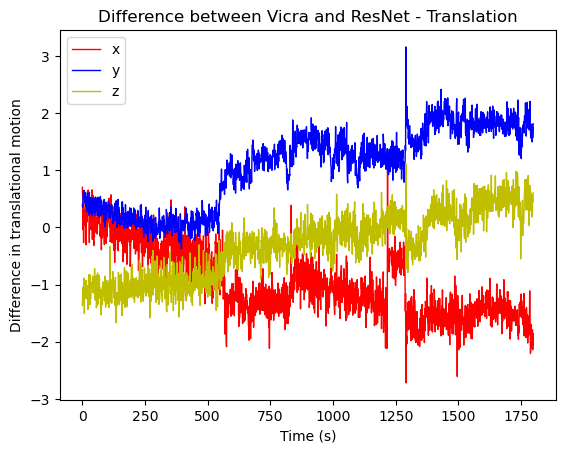

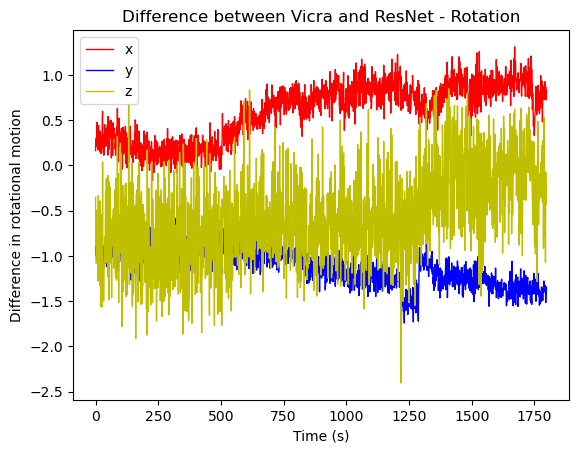

In [20]:
plot_diff_vicra_network('FPEB', 'MM537_27028', df_results_test, [3601,5399], 'ResNet')

In [21]:
# Print loss
print_loss('FPEB', 'MM537_27028', df_results_test, [3600, 5399])

Mean square errors between vicra and this network: 

Translation:
x:  1.32
y:  1.6
z:  0.43
Rotation:
x:  0.45
y:  1.29
z:  0.57


In [26]:
save_synthetic_vicra('FPEB', 'KS553_28529', df_results_test, [3600,5399], 'test')

In [ ]:
df_results_all=[]
y_list_all=[]
df_input_diff_all=[]

from copy import deepcopy

prediction_list = list()
for j in range(len(test_set)):

    df = df_test[j]

    #fixed reference time
    df_input_diff = mCTdata_vicra_toolbox.build_netinput_fixed_reference(df).reset_index()
    
    df_input_diff_all.append(df_input_diff)

    ##building testing dataloader
    test_dict = df_input_diff.to_dict('records')

    for i in range(len(test_dict)):
        x = test_dict[i]['ThreeD_Cloud_ref'].find('3D_Clouds_nii')
        fn_cloud1 = test_dict[i]['ThreeD_Cloud_ref'][0:x] + '3D_Clouds_nii_monai_resize'
        x = x+13
        y = test_dict[i]['ThreeD_Cloud_ref'].find('3D_cloud')
        fn_cloud2 =  test_dict[i]['ThreeD_Cloud_ref'][x:y] + '3D_cloud_monai_rz.nii'
        test_dict[i]['ThreeD_Cloud_ref'] = fn_cloud1 + fn_cloud2

        x = test_dict[i]['ThreeD_Cloud_mov'].find('3D_Clouds_nii')
        fn_cloud1 = test_dict[i]['ThreeD_Cloud_mov'][0:x] + '3D_Clouds_nii_monai_resize'
        x = x+13
        y = test_dict[i]['ThreeD_Cloud_mov'].find('3D_cloud')
        fn_cloud2 =  test_dict[i]['ThreeD_Cloud_mov'][x:y] + '3D_cloud_monai_rz.nii'
        test_dict[i]['ThreeD_Cloud_mov'] = fn_cloud1 + fn_cloud2

    # Create the Dataset
#     ds_test = monai.data.CacheDataset(data=test_dict, transform=train_transforms)
    ds_test = monai.data.Dataset(data=test_dict, transform=train_transforms)
    #ds_tr = monai.data.SmartCacheDataset(data=tr_dict,transform=train_transforms,replace_rate=1,cache_num=64,shuffle=True)
    # Create the DataLoader
    test_loader = monai.data.DataLoader(ds_test, batch_size=8, num_workers=2, collate_fn=list_data_collate)
    
    #calculate loss function and network output
    saved_model_path = os.path.join(MODEL_PATH,'PETRegNet-epoch=3339-val_loss=0.221.ckpt')
    loaded_model = PETRegNet.load_from_checkpoint(saved_model_path)

    loaded_model.eval()
    loaded_model.to(device)
    loss = 0
    loss_list = list()
    time_list = list()
    
    y_list = list()
    loss1 = []

    i=0
    for test_data in test_loader:
        x1 = test_data['ThreeD_Cloud_ref'].to(device)
        x2 = test_data['ThreeD_Cloud_mov'].to(device)
        time = test_data['delta_t']
        y = test_data['T'].cpu().numpy()
        y_test_temp = loaded_model(x1, x2).detach().cpu().numpy()
        l = len(y_test_temp)
        y_test=np.zeros((l,6))
        for jj in range(l):
            y_test[jj] = mCTdata_vicra_toolbox.RotTransMatrix_6Params(y_test_temp[jj], 1)
        

        loss = y-y_test
        for jj in range(l):
            loss1=sum(np.square(loss[jj]))/len(loss[jj])
            loss_list.append(loss1)
            time_list.append(time.numpy()[jj])
            prediction_list.append(y_test[jj])
            y_list.append(y[jj])
        
        del test_data
    df_results = pd.DataFrame()
    y_list_all.append(y_list)
    df_results['Time'] = time_list
    df_results['Loss'] = loss_list
    df_results_all.append(df_results)

In [ ]:
# save_synthetic_vicra('FDG', 'AO101', df_results_test, [3601,5399], 'test')

In [ ]:
from evaluation_toolbox import plot_networks_comparison
plot_networks_comparison('FDG', 'JO308', df_results_test, [3601, 5399], 'synthetic_vicra_test_AO101.csv', 'ResNet', 'DenseNet') # Mixing these two patients doesn't really make sense, it's just a test

In [ ]:
# Make boxplot to compare inference RMSE from different models

from evaluation_toolbox import make_boxplot

df_other_model=pd.read_csv('2d_mean_results', sep=',') # Load the df_results csv file from another training (this file has nothing to do with this study, it's just an example)

def delete_space_v(df):
    T_list=df['vicra parameters']
    new_T=[]
    for T_el in T_list:
        T_el=T_el.replace('[','')
        T_el=T_el.replace(']','')
        T_tmp=[]
        string_split=T_el.split(' ')
        for i in range(len(string_split)):
            if string_split[i] != '' and string_split[i] != ' ':
                T_tmp.append(float(string_split[i]))
        new_T.append(np.array(T_tmp))

    df['vicra parameters']=new_T
    return df

def delete_space_m(df):
    T_list=df['model parameters']
    new_T=[]
    for T_el in T_list:
        T_el=T_el.replace('[','')
        T_el=T_el.replace(']','')
        T_tmp=[]
        string_split=T_el.split(' ')
        for i in range(len(string_split)):
            if string_split[i] != '' and string_split[i] != ' ':
                T_tmp.append(float(string_split[i]))
        new_T.append(np.array(T_tmp))

    df['model parameters']=new_T
    return df

df_other_model=delete_space_v(df_other_model)
df_other_model=delete_space_m(df_other_model)

make_boxplot(df_results_test, df_other_model, models=['model1', 'model2'])